## Machine Learning with FastAI, Lesson 1 
#### Bruno Martins Valério Bomfim, 211039297

### Purpose

This articles aims to introduce fundamental concepts of Artificial Intelligence, Machine Learning and Deep Learning through a simple model that can differ images of musical instruments (violin and cello).


#### Collecting data

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for photos of violins and cellos.

In [2]:
from time import sleep
from fastai.vision.all import *

searches = 'violin','cello'
path = Path('images')

for s in searches:
    dest = (path/s)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{s} photo'))
    sleep(10)
    resize_images(path/s, max_size=400, dest=path/s)

Searching for 'violin photo'


/home/bruno/Documents/Coding/venv/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for 'cello photo'


#### Training the model

Removing photos that might not be downloaded correctly.

In [3]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

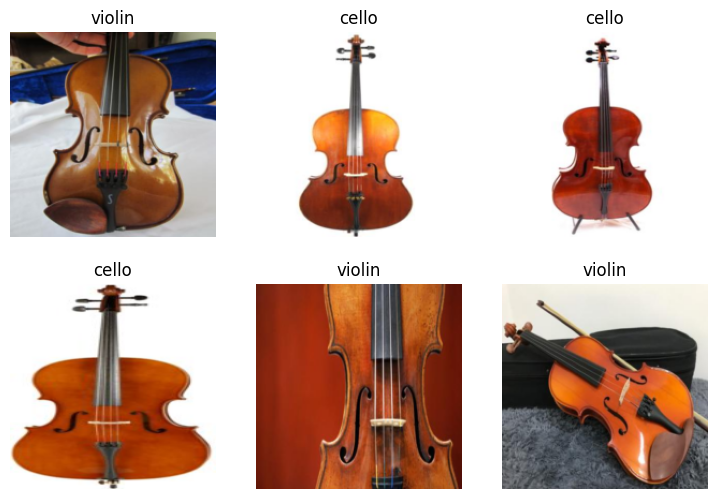

In [4]:
#Datablock is an object that contains a training set (the images used to create a model)
# and a validation set (the images used to check the accuracy of a model).

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #the inputs are images, and the outputs are categories 
    get_items=get_image_files, # get_image_files in a function which returns a list of all image files in a path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #split the data into training and validation sets randomly
    get_y=parent_label, # the labels (y values) is the name of the parent of each file
    item_tfms=[Resize(192, method='squish')] #resize
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [5]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/bruno/Documents/Coding/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bruno/Documents/Coding/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Using the model

In [16]:
result,_,probs = learn.predict(PILImage.create('images/violin/violin2.jpg'))
print(f"This is a: {result}.")
print(f"Probability it's a cello: {probs[0]:.4f}")

This is a: cello.
Probability it's a cello: 0.9504
